In [11]:
import numpy as np
import matplotlib.pyplot as plt 
from os import listdir

def load_dataset(path):
    """Load the data in file to ndarrays of x matrix and array of y labels.
    
    Args:
        path: path to the text file containing data.
    Returns:
        dataset: ndarray of x matrix. Shape (m, n)
        labels: array of labels. Shape (m,)
    """
    with open(path, 'r') as fr:
        first_row = fr.readline().strip().split('\t')
    x_cols = [i for i in range(len(first_row) - 1)]
    l_col = [len(first_row) - 1]

    dataset = np.loadtxt(path, dtype=float, delimiter='\t', usecols=x_cols)
    labels = np.loadtxt(path, dtype=float, delimiter='\t', usecols=l_col)
    return dataset, labels

def select_random_j(i, m):
    """Select a random j in m numbers with j not equal to m.
    
    Args:
        i: index of alpha i
        m: number of examples
    Returns:
        j: integer that's not i    
    """
    j = i
    while (j == i):
        j = int(np.random.uniform(0, m))
    return j

def clip_alpha(alpha_j, L, H):
    """Clip alpha to make it lie in the [L, H] interval.
    
    Args:
        alpha_j: jth alpha to be clipped
        L: the low boundary of the interval
        H: the high boundary of the interval
    Returns:
        alpha_j: the clipped alpha_j
    """
    if alpha_j > H:
        alpha_j = H
    elif alpha_j < L:
        alpha_j = L
    else:
        alpha_j = alpha_j
    return alpha_j

def smo_simplified(dataset, labels, C, tolerance, max_iter):
    """Use simplified SMO algorithm to solve for SVM.
    
    Args:
        dataset: ndarray of x matrix. Shape (m, n)
        labels: array of labels. Shape (m,)
        C: the violation parameter
        tolerance: 
        max_iter: maximum iteration allowed for SMO
    Returns:
        alpha: array of alpha parameters
        b: intercept parameter. Integer
    """
    m, n = dataset.shape
    alpha = np.zeros(m)
    b = 0
    iteration = 0

    while (iteration < max_iter):
        alpha_pair_changed = 0  # flag for a pair of alphas changed

        for i in range(m):
            f_i = (alpha * labels).dot(dataset.dot(dataset[i])) + b
            err_i = f_i - labels[i]

            # check if it fulfills the KKT conditions
            if (labels[i] * err_i < -tolerance and alpha[i] < C) or (labels[i] * err_i > tolerance and alpha[i] > 0):
                j = select_random_j(i, m)
                f_j = (alpha * labels).dot(dataset.dot(dataset[j])) + b
                err_j = f_j - labels[j]

                alpha_i_pre = np.copy(alpha[i])
                alpha_j_pre = np.copy(alpha[j])

                # choose the low and high boundary for alpha i & j
                if labels[i] == labels[j]:
                    L = max(0, alpha[j] + alpha[i] - C)
                    H = min(C, alpha[j] + alpha[i])
                else:
                    L = max(0, alpha[j] - alpha[i])
                    H = min(C, C + alpha[j] - alpha[i])
                
                # calculate eta and update alpha j
                eta = 2.0 * dataset[i].dot(dataset[j]) - dataset[i].dot(dataset[i]) - dataset[j].dot(dataset[j])
                if eta >= 0:
                    print('eta >= 0')
                    continue
                
                alpha[j] -= labels[j] * (err_i - err_j) / eta
                alpha[j] = clip_alpha(alpha[j], L, H)
                if abs(alpha[j] - alpha_j_pre < 1e-5):
                    print("alpha j not moving enough")
                    continue

                # update alpha i
                alpha[i] += labels[i] * labels[j] * (alpha_j_pre - alpha[j])    # update alpha i by the same amount as j

                # update b
                b1 = b - err_i - labels[i] * (alpha[i] - alpha_i_pre) * dataset[i].dot(dataset[i]) \
                               - labels[j] * (alpha[j] - alpha_j_pre) * dataset[j].dot(dataset[i])
                b2 = b - err_j - labels[i] * (alpha[i] - alpha_i_pre) * dataset[i].dot(dataset[j]) \
                               - labels[j] * (alpha[j] - alpha_j_pre) * dataset[j].dot(dataset[j])
                if 0 < alpha[i] and alpha[i] < C:
                    b = b1
                elif 0 < alpha[j] and alpha[j] < C:
                    b = b2
                else:
                    b = (b1 + b2) / 2

                # change flag
                alpha_pair_changed += 1
                print("Iteration: {0} i: {1}, pairs changed: {2}".format(iteration, i, alpha_pair_changed))

        if alpha_pair_changed == 0:  # if alpha pairs stays unchanged for max_iter, 
            iteration += 1           # then alphas are solved and can quit loop
        else:
            iteration = 0
        print('itration number: {}'.format(iteration))
    
    return alpha, b

#######################################Full SMO Algorithm#############################################

class ModelStructure(object):
# """Data Structure for storing parameters."""
    def __init__(self, dataset, labels, C, tolerance):
        """
        Args:
            dataset: ndarray of x matrix. Shape (m, n)
            labels: array of y labels. Shape (m,)
            C: slack parameter
            tolerance: error tolerance. floating point
        """
        self.dataset = dataset
        self.labels = labels
        self.C = C
        self.tolerance = tolerance
        self.m = dataset.shape[0]
        self.n = dataset.shape[1]
        self.alpha = np.zeros(self.m)
        self.b = 0
        self.err = np.zeros((self.m, 2))    # first column is a valid flag

def calculate_error(ds, k):
    """Calculate the error given alpha[k]
        
    Args:
        ds: the data structure of model
        k: kth alpha
    """
    err_k = (ds.alpha * ds.labels).dot(ds.dataset.dot(ds.dataset[k])) + ds.b - ds.labels[k]
    return err_k

def select_j(ds, i, err_i):
    """Given alpha[i], select alpha[j] that gives the maximum delta err
    
    Args:
        ds: the data structure of model
        i: the ith alpha in array
        err_i: the error calculated for alpha[i]
    Returns:
        best_j: j that renders the max delta error
        best_j_err: the error of the selected alpha j
    """
    # initialize j
    best_j = -1
    best_j_err = 0
    max_delta_err = 0
    ds.err[i] = [1, err_i]  # set valid 

    # take the index of alphas that has valid error cache
    valid_err_ind = [ind for ind in range(ds.m) if ds.err[ind, 0] > 0] 

    # loop through alpha that gives max delta err
    if len(valid_err_ind) > 1:
        for j in valid_err_ind:
            if j == i: continue
            err_j = calculate_error(ds, j)
            delta_err = abs(err_i - err_j)

            if delta_err > max_delta_err:
                best_j = j
                max_delta_err = delta_err
                best_j_err = err_j
        return best_j, best_j_err
    else:   # no valid error cache values (first round)
        best_j = select_random_j(i, ds.m)
        best_j_err = calculate_error(ds, best_j)
    return best_j, best_j_err

def smo_full(dataset, labels, C, tolerance, max_iter):
    """Full Platt SMO
    
    Args:
        dataset: ndarray of x matrix. Shape (m, n)
        labels: array of y labels. Shape (m,)
        C: slack parameter
        tolerance: error tolerance. floating point
        max_iter: maximum iterations
    Returns:
        ds.alpha: the alpha parameter of model
        ds.b: the b paramter of model data structure
    """
    ds = ModelStructure(dataset, labels, C, tolerance)
    iter = 0
    full_scan = True
    alpha_pair_changed = 0

    # Select alpha i: from support vector or from whole dataset
    # first, scan the whole dataset to change alpha
    # after first round, optimize the alpha within interval[0, C], these are support vectors.
    # if for sup_vec, no alpha pairs changed, scan full data again to update alpha pairs.
    # stop until: 1. no alpha pairs need to update, then keep scanning full data until reach max_cycle
    #             2. just update alpha pairs until reach maximum cycle
    while iter < max_iter and (alpha_pair_changed > 0 or full_scan):
        alpha_pair_changed = 0

        if full_scan:
            for i in range(ds.m):
                alpha_pair_changed += inner_loop(i, ds)
                print("fullset iteration: {} i: {}, pairs changed: {}".format(iter, i, alpha_pair_changed))
        else:
            # select from support vectors, i.e. 0 < alpha i < C
            non_bound_ind = [ind for ind in range(ds.m) if (ds.alpha[ind] > 0 and ds.alpha[ind] < ds.C)]

            for i in non_bound_ind:
                alpha_pair_changed += inner_loop(i, ds)
                print("non-bound iteration: {} i: {}, pairs changed: {}".format(iter, i, alpha_pair_changed))
            iter += 1

        if full_scan: 
            full_scan = False
        elif alpha_pair_changed == 0:
            full_scan = True
        print("iteration number: {}".format(iter))
    
    return ds.alpha, ds.b

def inner_loop(i, ds):
    """Inner loop to find and update alpha j.
    
    Args:
        i: index of the first alpha in pair
        ds: the data structure of SVM model
    Returns:
        0 if no alpha pairs changed. 1 if a pair of alpha changed.
    """
    err_i = calculate_error(ds, i)

    if (ds.labels[i] * err_i < -ds.tolerance and ds.alpha[i] < ds.C) or \
        (ds.labels[i] * err_i > ds.tolerance and ds.alpha[i] > 0):
        j, err_j = select_j(ds, i, err_i)

        alpha_i_pre = np.copy(ds.alpha[i])
        alpha_j_pre = np.copy(ds.alpha[j])

        if ds.labels[i] == ds.labels[j]:
            L = max(0, ds.alpha[j] + ds.alpha[i] - ds.C)
            H = min(ds.C, ds.alpha[j] + ds.alpha[i])
        else:
            L = max(0, ds.alpha[j] - ds.alpha[i])
            H = min(ds.C, ds.C + ds.alpha[j] - ds.alpha[i])
        if L == H: print("L==H"); return 0
        
        eta = 2.0 * ds.dataset[i].dot(ds.dataset[j]) - ds.dataset[i].dot(ds.dataset[i]) - ds.dataset[j].dot(ds.dataset[j])
        if eta >= 0: print("eta >= 0"); return 0

        ds.alpha[j] -= ds.labels[j] * (err_i - err_j) / eta
        ds.alpha[j] = clip_alpha(ds.alpha[j], L, H)
        ds.err[j] = [1, err_j]

        if abs(ds.alpha[j] - alpha_j_pre) < 1e-5:
            print("alpha j is not moving enough")
            return 0

        ds.alpha[i] += ds.labels[i] * ds.labels[j] * (alpha_j_pre - ds.alpha[j])
        ds.err[i] = [1, err_i]

        b1 = ds.b - err_i - ds.labels[i] * (ds.alpha[i] - alpha_i_pre) * ds.dataset[i].dot(ds.dataset[i]) \
                          - ds.labels[j] * (ds.alpha[j] - alpha_j_pre) * ds.dataset[j].dot(ds.dataset[i])
        b2 = ds.b - err_j - ds.labels[i] * (ds.alpha[i] - alpha_i_pre) * ds.dataset[i].dot(ds.dataset[j]) \
                          - ds.labels[j] * (ds.alpha[j] - alpha_j_pre) * ds.dataset[j].dot(ds.dataset[j])
        
        if 0 < ds.alpha[i] and ds.alpha[i] < ds.C:
            ds.b = b1
        elif 0 < ds.alpha[j] and ds.alpha[j] < ds.C:
            ds.b = b2
        else:
            ds.b = (b1 + b2) / 2
        
        return 1
    else:
        return 0
    
def plot_model(dataset, labels, alpha, b, save_path):
    """Plot the SVM classifier and support vectors
    
    Args:
        dataset: ndarray of x matrix. Shape (m, n)
        labels: array of labels. Shape (m,)
        alpha: array of alpha parameters
        b: intercept parameter. Integer
    """
    w = dataset.T.dot(alpha*labels)
    sup_vec = dataset[alpha > 0, :]

    fig, ax = plt.subplots()
    ax.plot(dataset[labels==1, 0], dataset[labels==1, 1], "bx", linewidth=2)
    ax.plot(dataset[labels==-1, 0], dataset[labels==-1, 1], 'go', linewidth=2)
    x1 = np.arange(min(dataset[:, 0])*0.8, max(dataset[:, 0])*1.2, 0.01)  # 20% margin
    x2 = -(b + w[0] * x1) / w[1]
    ax.plot(x1, x2, c = 'red', linewidth=2)
    ax.set_ylim(-7, 7)

    for i in range(sup_vec.shape[0]):
        ax.scatter(sup_vec[i, 0], sup_vec[i, 1], color='', marker='o', edgecolors='orange', s=200)
    
    plt.savefig(save_path)
    plt.show()
    

####################################SVM with Kernel Trick#########################################



def calculate_kernel(x_mat, x_i, kernel):
    """Calculate the distance or similarity between x[i] and all examples in x.
    
    Args:
        x_mat: ndarray of dataset. Shape (m, n)
        x_i: ith example of dataset. Array of shape (m,)
        kernel: tuple of kernel parameters. (str, float)
    Returns:
        k: result of <x, x_i>. Array of shape (m,)
    """
    m, n = x_mat.shape
    k = np.zeros(m)

    if kernel[0] == 'lin':  # linear kernel
        k = x_mat.dot(x_i)
    elif kernel[0] == 'rbf':    # radial bias function kernel
        delta = x_mat - x_i
        for i in range(m):
            k[i] = np.exp(-delta[i].dot(delta[i]) / kernel[1] ** 2)
    else:
        raise NameError('Unrecognizable kernel. Please use linear or radial biased kernel.')
    
    return k

class KernelSVM(ModelStructure):
    """Kernel SVM adds kernel parameter on ModelStructure."""
    def __init__(self, dataset, labels, C, tolerance, kernel):
        """
        Args:
            dataset: ndarray of x matrix. Shape (m, n)
            labels: array of y labels. Shape (m,)
            C: slack parameter
            tolerance: error tolerance. floating point
        """
        self.dataset = dataset
        self.labels = labels
        self.C = C
        self.tolerance = tolerance
        self.m = dataset.shape[0]
        self.n = dataset.shape[1]
        self.alpha = np.zeros(self.m)
        self.b = 0
        self.err = np.zeros((self.m, 2))    # first column is a valid flag
        self.kernel = kernel
        self.K = np.zeros((self.m, self.m))
        for i in range(self.m):
            self.K[:, i] = calculate_kernel(self.dataset, self.dataset[i, :], self.kernel)     # K[i, j] is the similarity between x_i and x_j


def calculate_error_ker(ds, k):
    """Calculate the error given alpha[k]
        
    Args:
        ds: the data structure of model
        k: kth alpha
    """
    err_k = (ds.alpha * ds.labels).dot(ds.K[:, k]) + ds.b - ds.labels[k]
    return err_k

def select_j_ker(ds, i, err_i):
    """Given alpha[i], select alpha[j] that gives the maximum delta err
    
    Args:
        ds: the data structure of model
        i: the ith alpha in array
        err_i: the error calculated for alpha[i]
    Returns:
        best_j: j that renders the max delta error
        best_j_err: the error of the selected alpha j
    """
    # initialize j
    best_j = -1
    best_j_err = 0
    max_delta_err = 0
    ds.err[i] = [1, err_i]  # set valid 

    # take the index of alphas that has valid error cache
    valid_err_ind = [ind for ind in range(ds.m) if ds.err[ind, 0] > 0] 

    # loop through alpha that gives max delta err
    if len(valid_err_ind) > 1:
        for j in valid_err_ind:
            if j == i: continue
            err_j = calculate_error_ker(ds, j)
            delta_err = abs(err_i - err_j)

            if delta_err > max_delta_err:
                best_j = j
                max_delta_err = delta_err
                best_j_err = err_j
        return best_j, best_j_err
    else:   # no valid error cache values (first round)
        best_j = select_random_j(i, ds.m)
        best_j_err = calculate_error_ker(ds, best_j)
    return best_j, best_j_err

def smo_kernel(dataset, labels, C, tolerance, kernel, max_iter):
    """Full Platt SMO
    
    Args:
        dataset: ndarray of x matrix. Shape (m, n)
        labels: array of y labels. Shape (m,)
        C: slack parameter
        tolerance: error tolerance. floating point
        max_iter: maximum iterations
    Returns:
        ds.alpha: the alpha parameter of model
        ds.b: the b paramter of model data structure
    """
    ds = KernelSVM(dataset=dataset, labels=labels, C=C, tolerance=tolerance, kernel=kernel)
    iter = 0
    full_scan = True
    alpha_pair_changed = 0

    # Select alpha i: from support vector or from whole dataset
    # first, scan the whole dataset to change alpha
    # after first round, optimize the alpha within interval[0, C], these are support vectors.
    # if for sup_vec, no alpha pairs changed, scan full data again to update alpha pairs.
    # stop until: 1. no alpha pairs need to update, then keep scanning full data until reach max_cycle
    #             2. just update alpha pairs until reach maximum cycle
    while iter < max_iter and (alpha_pair_changed > 0 or full_scan):
        alpha_pair_changed = 0

        if full_scan:
            for i in range(ds.m):
                alpha_pair_changed += inner_loop_ker(i, ds)
                print("fullset iteration: {} i: {}, pairs changed: {}".format(iter, i, alpha_pair_changed))
        else:
            # select from support vectors, i.e. 0 < alpha i < C
            non_bound_ind = [ind for ind in range(ds.m) if ds.alpha[ind] > 0 and ds.alpha[ind] < ds.C]

            for i in non_bound_ind:
                alpha_pair_changed += inner_loop_ker(i, ds)
                print("non-bound iteration: {} i: {}, pairs changed: {}".format(iter, i, alpha_pair_changed))
            iter += 1

        if full_scan: 
            full_scan = False
        elif alpha_pair_changed == 0:
            full_scan = True
        print("iteration number: {}".format(iter))
    
    return ds.alpha, ds.b

def inner_loop_ker(i, ds):
    """Inner loop to find and update alpha j.
    
    Args:
        i: index of the first alpha in pair
        ds: the data structure of SVM model
    Returns:
        0 if no alpha pairs changed. 1 if a pair of alpha changed.
    """
    err_i = calculate_error_ker(ds, i)

    if (ds.labels[i] * err_i < -ds.tolerance and ds.alpha[i] < ds.C) or \
        (ds.labels[i] * err_i > ds.tolerance and ds.alpha[i] > 0):
        j, err_j = select_j_ker(ds, i, err_i)

        alpha_i_pre = np.copy(ds.alpha[i])
        alpha_j_pre = np.copy(ds.alpha[j])

        if ds.labels[i] == ds.labels[j]:
            L = max(0, ds.alpha[j] + ds.alpha[i] - ds.C)
            H = min(ds.C, ds.alpha[j] + ds.alpha[i])
        else:
            L = max(0, ds.alpha[j] - ds.alpha[i])
            H = min(ds.C, ds.C + ds.alpha[j] - ds.alpha[i])
        if L == H: print("L==H"); return 0
        
        eta = 2.0 * ds.K[i, j] - ds.K[i, i] - ds.K[j, j]
        if eta >= 0: print("eta >= 0"); return 0

        ds.alpha[j] -= ds.labels[j] * (err_i - err_j) / eta
        ds.alpha[j] = clip_alpha(ds.alpha[j], L, H)
        ds.err[j] = [1, err_j]

        if abs(ds.alpha[j] - alpha_j_pre) < 1e-5:
            print("alpha j is not moving enough")
            return 0

        ds.alpha[i] += ds.labels[i] * ds.labels[j] * (alpha_j_pre - ds.alpha[j])
        ds.err[i] = [1, err_i]

        b1 = ds.b - err_i - ds.labels[i] * (ds.alpha[i] - alpha_i_pre) * ds.K[i, i] \
                          - ds.labels[j] * (ds.alpha[j] - alpha_j_pre) * ds.K[j, i]
        b2 = ds.b - err_j - ds.labels[i] * (ds.alpha[i] - alpha_i_pre) * ds.K[i, j] \
                          - ds.labels[j] * (ds.alpha[j] - alpha_j_pre) * ds.K[j, j]
        
        if 0 < ds.alpha[i] and ds.alpha[i] < ds.C:
            ds.b = b1
        elif 0 < ds.alpha[j] and ds.alpha[j] < ds.C:
            ds.b = b2
        else:
            ds.b = (b1 + b2) / 2
        
        return 1
    else:
        return 0

########################################Classify Digits#########################################
def img2Vec(filename):
    '''
    input: the filedir of each img txt file
    output: a list of length 1024
    '''
    arr = []
    fr = open(filename)
    for i in range(32):
        line = fr.readline().strip()
        arr.extend(line)
    return arr

def load_images(file_dir):
    """Load images from directory to ndarrays
    
    Args:
        file_dir: directory to txt files containing digits
    Returns:
        dataset: ndarray of shape (m, 2014) while m is the number of txt files
        labels: array of shape (m,) -1 if image is digit 9, 1 if otherwise
    """
    train_file_list = listdir(file_dir)
    m = len(train_file_list)
    dataset = np.zeros((m, 1024))   # each digit image has 1024 features
    labels = np.zeros(m)

    for i in range(m):
        file_name = train_file_list[i]
        label = int(file_name.split('_')[0])
       
        if label == 9:
            labels[i] = -1
        else:
            labels[i] = 1
 
        dataset[i] = img2Vec('{}/{}'.format(file_dir, file_name))
    
    return dataset, labels

def classify_digits():
    """To classify digits using SVM based on RBF"""
    x_train, y_train = load_images('trainingDigits')
    x_test, y_test = load_images('testDigits')

    alpha, b = smo_kernel(x_train, y_train, 200, 0.0001, ('rbf', 10), 10000)
    sv = x_train[alpha > 0]
    sv_label = y_train[alpha > 0]
    m = len(alpha)
    
    # training error
    err_cnt = 0
    for i in range(m):
        ker_i = calculate_kernel(sv, x_train[i, :], ('rbf', 10))
        pred = (alpha[alpha > 0]*sv_label).dot(ker_i) + b

        if pred * y_train[i] < 0: err_cnt += 1
    print("Training error rate is {}".format(err_cnt / m))

    # test error
    m_test = x_test.shape[0]
    err_cnt = 0
    for i in range(m_test):
        ker_i = calculate_kernel(sv, x_test[i, :], ('rbf', 10))
        pred = (alpha[alpha > 0]*sv_label).dot(ker_i) + b

        if pred * y_test[i] < 0: err_cnt += 1
    print("Training error rate is {}".format(err_cnt / m_test))

In [288]:
dataset, labels = load_dataset('testSet.txt')

In [295]:
alpha, b = smo_simplified(dataset, labels, 0.6, 0.001, 100)

alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
Iteration: 0 i: 3, pairs changed: 1
Iteration: 0 i: 5, pairs changed: 2
Iteration: 0 i: 8, pairs changed: 3
alpha j not moving enough
alpha j not moving enough
Iteration: 0 i: 17, pairs changed: 4
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
Iteration: 0 i: 36, pairs changed: 5
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
Iteration: 0 i: 55, pairs changed: 6
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 0
alpha j not moving enough
alpha j not moving enough
Iteration: 0 i: 3, pairs changed: 1
Iteration: 0 i: 4, pairs changed: 2
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not mo

alpha j not moving enough
alpha j not moving enough
itration number: 3
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 4
alpha j not moving enough
alpha j not moving enough
Iteration: 4 i: 29, pairs changed: 1
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 0
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 1
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 2
Iteration: 2 i: 23, pairs changed: 1
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 0
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha 

alpha j not moving enough
alpha j not moving enough
itration number: 6
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 7
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 8
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 9
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 10
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 11
alpha j not moving enough
alpha j not moving enough


alpha j not moving enough
itration number: 10
alpha j not moving enough
itration number: 11
alpha j not moving enough
itration number: 12
alpha j not moving enough
itration number: 13
alpha j not moving enough
itration number: 14
alpha j not moving enough
itration number: 15
alpha j not moving enough
itration number: 16
alpha j not moving enough
itration number: 17
alpha j not moving enough
itration number: 18
alpha j not moving enough
itration number: 19
alpha j not moving enough
itration number: 20
alpha j not moving enough
itration number: 21
alpha j not moving enough
itration number: 22
alpha j not moving enough
itration number: 23
alpha j not moving enough
itration number: 24
alpha j not moving enough
itration number: 25
alpha j not moving enough
itration number: 26
alpha j not moving enough
itration number: 27
alpha j not moving enough
itration number: 28
alpha j not moving enough
itration number: 29
alpha j not moving enough
itration number: 30
alpha j not moving enough
itration

alpha j not moving enough
alpha j not moving enough
itration number: 5
alpha j not moving enough
alpha j not moving enough
itration number: 6
alpha j not moving enough
alpha j not moving enough
itration number: 7
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 8
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 9
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 10
a

alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 9
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 10
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 11
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 12
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 13
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 14
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 15
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 16
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 17
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number

itration number: 48
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 49
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 50
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 51
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 52
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 53
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 54
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 55
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration

itration number: 5
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 6
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 7
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 8
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 9
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 10
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
a

alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 5
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 6
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 7
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 8
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 9
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 10
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 11
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 12
alpha j not moving enough
alpha j not m

itration number: 37
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 38
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 39
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
Iteration: 39 i: 55, pairs changed: 1
itration number: 0
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 1
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 2
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 3
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 4
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 5
alpha j not moving enough
alpha j not moving enough
alpha j 

itration number: 10
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 11
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 12
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 13
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 14
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 15
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 16
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 17
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration

itration number: 44
alpha j not moving enough
alpha j not moving enough
itration number: 45
alpha j not moving enough
alpha j not moving enough
itration number: 46
alpha j not moving enough
alpha j not moving enough
itration number: 47
alpha j not moving enough
alpha j not moving enough
itration number: 48
alpha j not moving enough
alpha j not moving enough
itration number: 49
alpha j not moving enough
alpha j not moving enough
itration number: 50
alpha j not moving enough
alpha j not moving enough
itration number: 51
alpha j not moving enough
alpha j not moving enough
itration number: 52
alpha j not moving enough
alpha j not moving enough
itration number: 53
alpha j not moving enough
alpha j not moving enough
itration number: 54
alpha j not moving enough
alpha j not moving enough
itration number: 55
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 56
alpha j not moving enough
alpha j not 

alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 83
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 84
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 85
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itra

alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 4
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 5
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 6
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 7
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 8
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 9
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
al

alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 3
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 4
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 5
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 6
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 7
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 8
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 9
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 10
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 11
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
Iteration: 11 i: 55, 

itration number: 76
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 77
alpha j not moving enough
Iteration: 77 i: 29, pairs changed: 1
alpha j not moving enough
itration number: 0
alpha j not moving enough
alpha j not moving enough
itration number: 1
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 2
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
Iteration: 2 i: 55, pairs changed: 1
itration number: 0
alpha j not moving enough
alpha j not moving enough
itration number: 1
alpha j not moving enough
alpha j not moving enough
itration number: 2
alpha j not moving enough
alpha j not moving enough
itration number: 3
alpha j not moving enough
alpha j not moving enough
itration number: 4
alpha j not moving enough
alpha j not moving enough
itration number: 5
alpha j not moving enough
alpha j not moving enough
itration num

itration number: 25
itration number: 26
itration number: 27
itration number: 28
itration number: 29
itration number: 30
itration number: 31
itration number: 32
itration number: 33
itration number: 34
itration number: 35
itration number: 36
itration number: 37
itration number: 38
itration number: 39
itration number: 40
itration number: 41
itration number: 42
itration number: 43
itration number: 44
itration number: 45
itration number: 46
itration number: 47
itration number: 48
itration number: 49
itration number: 50
itration number: 51
itration number: 52
itration number: 53
itration number: 54
itration number: 55
itration number: 56
itration number: 57
itration number: 58
itration number: 59
itration number: 60
itration number: 61
itration number: 62
itration number: 63
itration number: 64
itration number: 65
itration number: 66
itration number: 67
itration number: 68
itration number: 69
itration number: 70
itration number: 71
itration number: 72
itration number: 73
itration number: 74


In [234]:
alpha[alpha > 0]

array([0.14551432, 0.05716861])

In [293]:
plot_model(dataset, labels, alpha, b)

TypeError: plot_model() missing 1 required positional argument: 'save_path'

In [298]:
alpha2, b2 = smo_full(dataset, labels, 0.6, 0.001, 100)

fullset iteration: 0 i: 0, pairs changed: 1
fullset iteration: 0 i: 1, pairs changed: 1
fullset iteration: 0 i: 2, pairs changed: 2
fullset iteration: 0 i: 3, pairs changed: 2
fullset iteration: 0 i: 4, pairs changed: 2
fullset iteration: 0 i: 5, pairs changed: 3
fullset iteration: 0 i: 6, pairs changed: 3
fullset iteration: 0 i: 7, pairs changed: 3
alpha j is not moving enough
fullset iteration: 0 i: 8, pairs changed: 3
fullset iteration: 0 i: 9, pairs changed: 3
alpha j is not moving enough
fullset iteration: 0 i: 10, pairs changed: 3
fullset iteration: 0 i: 11, pairs changed: 3
fullset iteration: 0 i: 12, pairs changed: 3
fullset iteration: 0 i: 13, pairs changed: 3
fullset iteration: 0 i: 14, pairs changed: 3
fullset iteration: 0 i: 15, pairs changed: 3
fullset iteration: 0 i: 16, pairs changed: 3
fullset iteration: 0 i: 17, pairs changed: 4
fullset iteration: 0 i: 18, pairs changed: 5
fullset iteration: 0 i: 19, pairs changed: 5
L==H
fullset iteration: 0 i: 20, pairs changed: 5
L=

C:\Users\ziman\anaconda3\lib\site-packages\ipykernel_launcher.py:329: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


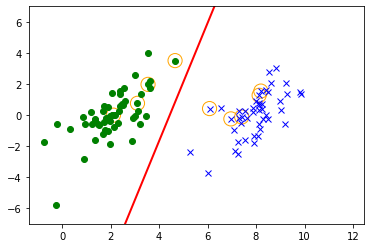

In [263]:
plot_model(dataset, labels, alpha2, b2)

In [315]:
dat, lbl = load_dataset('testSetRBF.txt')
alpha3, b3 = smo_kernel(dat, lbl, 200, 0.0001, ('rbf', 1.3), 10000)

sv = dat[alpha3 > 0]   # support vectors
sv_label = lbl[alpha3 > 0]
m = len(alpha3)
k = np.zeros(m)

# training error
err_cnt = 0
for ind in range(m):
    ker_i = calculate_kernel(sv, dat[ind, :], ('rbf', 1.3))
    pred = (alpha3[alpha3 > 0]*sv_label).dot(ker_i) + b3
    
    if pred * lbl[ind] < 0:
        err_cnt += 1   
print("Training error rate is {}".format(err_cnt / m))

# test error
dat_test, label_test = load_dataset('testSetRBF2.txt')
m_test = dat_test.shape[0]
err_cnt = 0
for ind in range(m_test):
    ker_i = calculate_kernel(sv, dat_test[ind, :], ('rbf', 1.3))
    pred = (alpha3[alpha3 > 0]*sv_label).dot(ker_i) + b3
    
    if pred * label_test[ind] < 0:
        err_cnt += 1   
print("Training error rate is {}".format(err_cnt / m_test))

L==H
fullset iteration: 0 i: 0, pairs changed: 0
fullset iteration: 0 i: 1, pairs changed: 1
fullset iteration: 0 i: 2, pairs changed: 2
fullset iteration: 0 i: 3, pairs changed: 3
fullset iteration: 0 i: 4, pairs changed: 3
fullset iteration: 0 i: 5, pairs changed: 4
fullset iteration: 0 i: 6, pairs changed: 4
fullset iteration: 0 i: 7, pairs changed: 5
fullset iteration: 0 i: 8, pairs changed: 5
fullset iteration: 0 i: 9, pairs changed: 5
fullset iteration: 0 i: 10, pairs changed: 6
fullset iteration: 0 i: 11, pairs changed: 7
fullset iteration: 0 i: 12, pairs changed: 7
fullset iteration: 0 i: 13, pairs changed: 8
fullset iteration: 0 i: 14, pairs changed: 9
fullset iteration: 0 i: 15, pairs changed: 10
fullset iteration: 0 i: 16, pairs changed: 11
fullset iteration: 0 i: 17, pairs changed: 12
fullset iteration: 0 i: 18, pairs changed: 13
fullset iteration: 0 i: 19, pairs changed: 14
fullset iteration: 0 i: 20, pairs changed: 14
fullset iteration: 0 i: 21, pairs changed: 15
alpha j 

In [12]:
classify_digits()

L==H
fullset iteration: 0 i: 0, pairs changed: 0
fullset iteration: 0 i: 1, pairs changed: 1
fullset iteration: 0 i: 2, pairs changed: 2
fullset iteration: 0 i: 3, pairs changed: 3
fullset iteration: 0 i: 4, pairs changed: 4
fullset iteration: 0 i: 5, pairs changed: 5
fullset iteration: 0 i: 6, pairs changed: 6
fullset iteration: 0 i: 7, pairs changed: 7
fullset iteration: 0 i: 8, pairs changed: 8
fullset iteration: 0 i: 9, pairs changed: 9
fullset iteration: 0 i: 10, pairs changed: 10
L==H
fullset iteration: 0 i: 11, pairs changed: 10
fullset iteration: 0 i: 12, pairs changed: 11
fullset iteration: 0 i: 13, pairs changed: 12
fullset iteration: 0 i: 14, pairs changed: 13
fullset iteration: 0 i: 15, pairs changed: 14
fullset iteration: 0 i: 16, pairs changed: 15
fullset iteration: 0 i: 17, pairs changed: 16
alpha j is not moving enough
fullset iteration: 0 i: 18, pairs changed: 16
fullset iteration: 0 i: 19, pairs changed: 17
fullset iteration: 0 i: 20, pairs changed: 18
fullset iterati

fullset iteration: 0 i: 234, pairs changed: 62
fullset iteration: 0 i: 235, pairs changed: 63
fullset iteration: 0 i: 236, pairs changed: 64
fullset iteration: 0 i: 237, pairs changed: 64
fullset iteration: 0 i: 238, pairs changed: 65
fullset iteration: 0 i: 239, pairs changed: 65
fullset iteration: 0 i: 240, pairs changed: 65
fullset iteration: 0 i: 241, pairs changed: 65
fullset iteration: 0 i: 242, pairs changed: 66
fullset iteration: 0 i: 243, pairs changed: 67
fullset iteration: 0 i: 244, pairs changed: 68
fullset iteration: 0 i: 245, pairs changed: 69
fullset iteration: 0 i: 246, pairs changed: 70
alpha j is not moving enough
fullset iteration: 0 i: 247, pairs changed: 70
fullset iteration: 0 i: 248, pairs changed: 71
fullset iteration: 0 i: 249, pairs changed: 72
fullset iteration: 0 i: 250, pairs changed: 72
fullset iteration: 0 i: 251, pairs changed: 72
fullset iteration: 0 i: 252, pairs changed: 73
fullset iteration: 0 i: 253, pairs changed: 74
fullset iteration: 0 i: 254, pa

non-bound iteration: 0 i: 130, pairs changed: 35
non-bound iteration: 0 i: 131, pairs changed: 36
non-bound iteration: 0 i: 146, pairs changed: 37
non-bound iteration: 0 i: 150, pairs changed: 38
non-bound iteration: 0 i: 158, pairs changed: 39
non-bound iteration: 0 i: 161, pairs changed: 40
non-bound iteration: 0 i: 162, pairs changed: 41
non-bound iteration: 0 i: 172, pairs changed: 42
non-bound iteration: 0 i: 175, pairs changed: 43
non-bound iteration: 0 i: 179, pairs changed: 44
non-bound iteration: 0 i: 182, pairs changed: 45
non-bound iteration: 0 i: 188, pairs changed: 46
non-bound iteration: 0 i: 189, pairs changed: 47
non-bound iteration: 0 i: 198, pairs changed: 48
non-bound iteration: 0 i: 199, pairs changed: 49
non-bound iteration: 0 i: 200, pairs changed: 50
non-bound iteration: 0 i: 201, pairs changed: 51
non-bound iteration: 0 i: 202, pairs changed: 51
non-bound iteration: 0 i: 203, pairs changed: 52
non-bound iteration: 0 i: 204, pairs changed: 53
non-bound iteration:

alpha j is not moving enough
non-bound iteration: 1 i: 319, pairs changed: 15
alpha j is not moving enough
non-bound iteration: 1 i: 322, pairs changed: 15
alpha j is not moving enough
non-bound iteration: 1 i: 323, pairs changed: 15
alpha j is not moving enough
non-bound iteration: 1 i: 325, pairs changed: 15
alpha j is not moving enough
non-bound iteration: 1 i: 328, pairs changed: 15
alpha j is not moving enough
non-bound iteration: 1 i: 329, pairs changed: 15
alpha j is not moving enough
non-bound iteration: 1 i: 330, pairs changed: 15
alpha j is not moving enough
non-bound iteration: 1 i: 331, pairs changed: 15
alpha j is not moving enough
non-bound iteration: 1 i: 332, pairs changed: 15
alpha j is not moving enough
non-bound iteration: 1 i: 334, pairs changed: 15
alpha j is not moving enough
non-bound iteration: 1 i: 335, pairs changed: 15
alpha j is not moving enough
non-bound iteration: 1 i: 337, pairs changed: 15
alpha j is not moving enough
non-bound iteration: 1 i: 339, pair

alpha j is not moving enough
fullset iteration: 3 i: 7, pairs changed: 0
L==H
fullset iteration: 3 i: 8, pairs changed: 0
fullset iteration: 3 i: 9, pairs changed: 0
alpha j is not moving enough
fullset iteration: 3 i: 10, pairs changed: 0
L==H
fullset iteration: 3 i: 11, pairs changed: 0
L==H
fullset iteration: 3 i: 12, pairs changed: 0
alpha j is not moving enough
fullset iteration: 3 i: 13, pairs changed: 0
alpha j is not moving enough
fullset iteration: 3 i: 14, pairs changed: 0
alpha j is not moving enough
fullset iteration: 3 i: 15, pairs changed: 0
alpha j is not moving enough
fullset iteration: 3 i: 16, pairs changed: 0
fullset iteration: 3 i: 17, pairs changed: 0
L==H
fullset iteration: 3 i: 18, pairs changed: 0
fullset iteration: 3 i: 19, pairs changed: 0
alpha j is not moving enough
fullset iteration: 3 i: 20, pairs changed: 0
alpha j is not moving enough
fullset iteration: 3 i: 21, pairs changed: 0
alpha j is not moving enough
fullset iteration: 3 i: 22, pairs changed: 0
L=

alpha j is not moving enough
fullset iteration: 3 i: 161, pairs changed: 2
alpha j is not moving enough
fullset iteration: 3 i: 162, pairs changed: 2
alpha j is not moving enough
fullset iteration: 3 i: 163, pairs changed: 2
alpha j is not moving enough
fullset iteration: 3 i: 164, pairs changed: 2
fullset iteration: 3 i: 165, pairs changed: 2
fullset iteration: 3 i: 166, pairs changed: 2
fullset iteration: 3 i: 167, pairs changed: 2
fullset iteration: 3 i: 168, pairs changed: 2
fullset iteration: 3 i: 169, pairs changed: 2
fullset iteration: 3 i: 170, pairs changed: 2
fullset iteration: 3 i: 171, pairs changed: 2
alpha j is not moving enough
fullset iteration: 3 i: 172, pairs changed: 2
alpha j is not moving enough
fullset iteration: 3 i: 173, pairs changed: 2
fullset iteration: 3 i: 174, pairs changed: 2
alpha j is not moving enough
fullset iteration: 3 i: 175, pairs changed: 2
alpha j is not moving enough
fullset iteration: 3 i: 176, pairs changed: 2
L==H
fullset iteration: 3 i: 177

fullset iteration: 3 i: 359, pairs changed: 5
fullset iteration: 3 i: 360, pairs changed: 5
L==H
fullset iteration: 3 i: 361, pairs changed: 5
alpha j is not moving enough
fullset iteration: 3 i: 362, pairs changed: 5
alpha j is not moving enough
fullset iteration: 3 i: 363, pairs changed: 5
alpha j is not moving enough
fullset iteration: 3 i: 364, pairs changed: 5
fullset iteration: 3 i: 365, pairs changed: 5
L==H
fullset iteration: 3 i: 366, pairs changed: 5
L==H
fullset iteration: 3 i: 367, pairs changed: 5
fullset iteration: 3 i: 368, pairs changed: 5
L==H
fullset iteration: 3 i: 369, pairs changed: 5
alpha j is not moving enough
fullset iteration: 3 i: 370, pairs changed: 5
L==H
fullset iteration: 3 i: 371, pairs changed: 5
L==H
fullset iteration: 3 i: 372, pairs changed: 5
L==H
fullset iteration: 3 i: 373, pairs changed: 5
alpha j is not moving enough
fullset iteration: 3 i: 374, pairs changed: 5
L==H
fullset iteration: 3 i: 375, pairs changed: 5
fullset iteration: 3 i: 376, pair

alpha j is not moving enough
non-bound iteration: 3 i: 306, pairs changed: 0
alpha j is not moving enough
non-bound iteration: 3 i: 311, pairs changed: 0
alpha j is not moving enough
non-bound iteration: 3 i: 315, pairs changed: 0
alpha j is not moving enough
non-bound iteration: 3 i: 316, pairs changed: 0
alpha j is not moving enough
non-bound iteration: 3 i: 317, pairs changed: 0
alpha j is not moving enough
non-bound iteration: 3 i: 318, pairs changed: 0
alpha j is not moving enough
non-bound iteration: 3 i: 319, pairs changed: 0
alpha j is not moving enough
non-bound iteration: 3 i: 321, pairs changed: 0
alpha j is not moving enough
non-bound iteration: 3 i: 322, pairs changed: 0
alpha j is not moving enough
non-bound iteration: 3 i: 323, pairs changed: 0
alpha j is not moving enough
non-bound iteration: 3 i: 325, pairs changed: 0
alpha j is not moving enough
non-bound iteration: 3 i: 328, pairs changed: 0
alpha j is not moving enough
non-bound iteration: 3 i: 329, pairs changed: 0

L==H
fullset iteration: 4 i: 195, pairs changed: 0
fullset iteration: 4 i: 196, pairs changed: 0
L==H
fullset iteration: 4 i: 197, pairs changed: 0
alpha j is not moving enough
fullset iteration: 4 i: 198, pairs changed: 0
alpha j is not moving enough
fullset iteration: 4 i: 199, pairs changed: 0
alpha j is not moving enough
fullset iteration: 4 i: 200, pairs changed: 0
alpha j is not moving enough
fullset iteration: 4 i: 201, pairs changed: 0
fullset iteration: 4 i: 202, pairs changed: 0
fullset iteration: 4 i: 203, pairs changed: 0
alpha j is not moving enough
fullset iteration: 4 i: 204, pairs changed: 0
alpha j is not moving enough
fullset iteration: 4 i: 205, pairs changed: 0
fullset iteration: 4 i: 206, pairs changed: 0
alpha j is not moving enough
fullset iteration: 4 i: 207, pairs changed: 0
alpha j is not moving enough
fullset iteration: 4 i: 208, pairs changed: 0
alpha j is not moving enough
fullset iteration: 4 i: 209, pairs changed: 0
alpha j is not moving enough
fullset it

alpha j is not moving enough
fullset iteration: 4 i: 387, pairs changed: 0
alpha j is not moving enough
fullset iteration: 4 i: 388, pairs changed: 0
alpha j is not moving enough
fullset iteration: 4 i: 389, pairs changed: 0
L==H
fullset iteration: 4 i: 390, pairs changed: 0
alpha j is not moving enough
fullset iteration: 4 i: 391, pairs changed: 0
alpha j is not moving enough
fullset iteration: 4 i: 392, pairs changed: 0
fullset iteration: 4 i: 393, pairs changed: 0
alpha j is not moving enough
fullset iteration: 4 i: 394, pairs changed: 0
L==H
fullset iteration: 4 i: 395, pairs changed: 0
alpha j is not moving enough
fullset iteration: 4 i: 396, pairs changed: 0
L==H
fullset iteration: 4 i: 397, pairs changed: 0
alpha j is not moving enough
fullset iteration: 4 i: 398, pairs changed: 0
alpha j is not moving enough
fullset iteration: 4 i: 399, pairs changed: 0
fullset iteration: 4 i: 400, pairs changed: 0
alpha j is not moving enough
fullset iteration: 4 i: 401, pairs changed: 0
itera